# Classifying Depression

The National Institute of Mental Health describes depression as a “serious mood disorder”. Access to mental health services is challenging for people living in rural areas and they may not have the support they need. This may be due to their economic state, lack of education about these services, living at a distance far from mental health services, friends, family, etc. The lack of access to mental health services may lead to increased rates of depression in people living in rural areas.
 
In this project, we will be creating a classification model to predict whether or not someone from a rural area is likely to be depressed or not, based on their sex, age, whether or not they’re married, their level of education, the number of children they have, and how much money they make.
 
For our project we extracted our data from [*Kaggle*](https://www.kaggle.com/datasets/diegobabativa/depression). The data comes from a study that was conducted on people living in rural areas.

# Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
library(ggplot2)
library(cowplot)

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 20, repr.plot.height = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading and cleaning the data

In [2]:
depression_data <- read_csv("https://raw.githubusercontent.com/DonaldKLee/DSCI-100-Group-Project/main/data/b_depressed.csv") |>
    mutate(
        depression_result = as_factor(ifelse(depressed>0, "depressed", "not depressed")),
        assets=(gained_asset+durable_asset+save_asset),
        expenses=(living_expenses+other_expenses+farm_expenses)) |>
    select(sex, Age, Married, Number_children, total_members, assets, expenses, depression_result)

depression_data

Rows: 1429 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (23): Survey_id, Ville_id, sex, Age, Married, Number_children, education...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,28,1,4,5,75174120,86258781,not depressed
1,23,1,3,5,75174120,86258781,depressed
1,22,1,3,5,75174120,86258781,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,66,0,0,1,87865276,79534107,depressed
1,51,1,1,5,75174120,86258781,not depressed
1,33,0,4,5,152396315,37702850,not depressed


###### Figure 1. Data from the depression dataset

## Summary of the training data

In [3]:
set.seed(2000)

depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)
depression_train <- training(depression_data_split)

depression_data_summary <- depression_train |>
    group_by(depression_result) |>
    summarize(mean_sex = round(mean(sex, na.rm = TRUE)), 
              mean_age = mean(Age, na.rm = TRUE), 
              mean_married = round(mean(Married, na.rm = TRUE)),
              mean_number_children = round(mean(Number_children, na.rm = TRUE)),
              mean_total_members = round(mean(total_members, na.rm = TRUE)),
              mean_assets = mean(assets, na.rm = TRUE),
              mean_expenses = mean(expenses, na.rm = TRUE),
              n=n())
    
depression_data_summary

depression_result,mean_sex,mean_age,mean_married,mean_number_children,mean_total_members,mean_assets,mean_expenses,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
not depressed,1,33.95633,1,3,5,88034652,100433599,893
depressed,1,38.09551,1,3,5,88954426,100347510,178


###### Figure 2. Summary of the data from the depression dataset

## Data Visualization

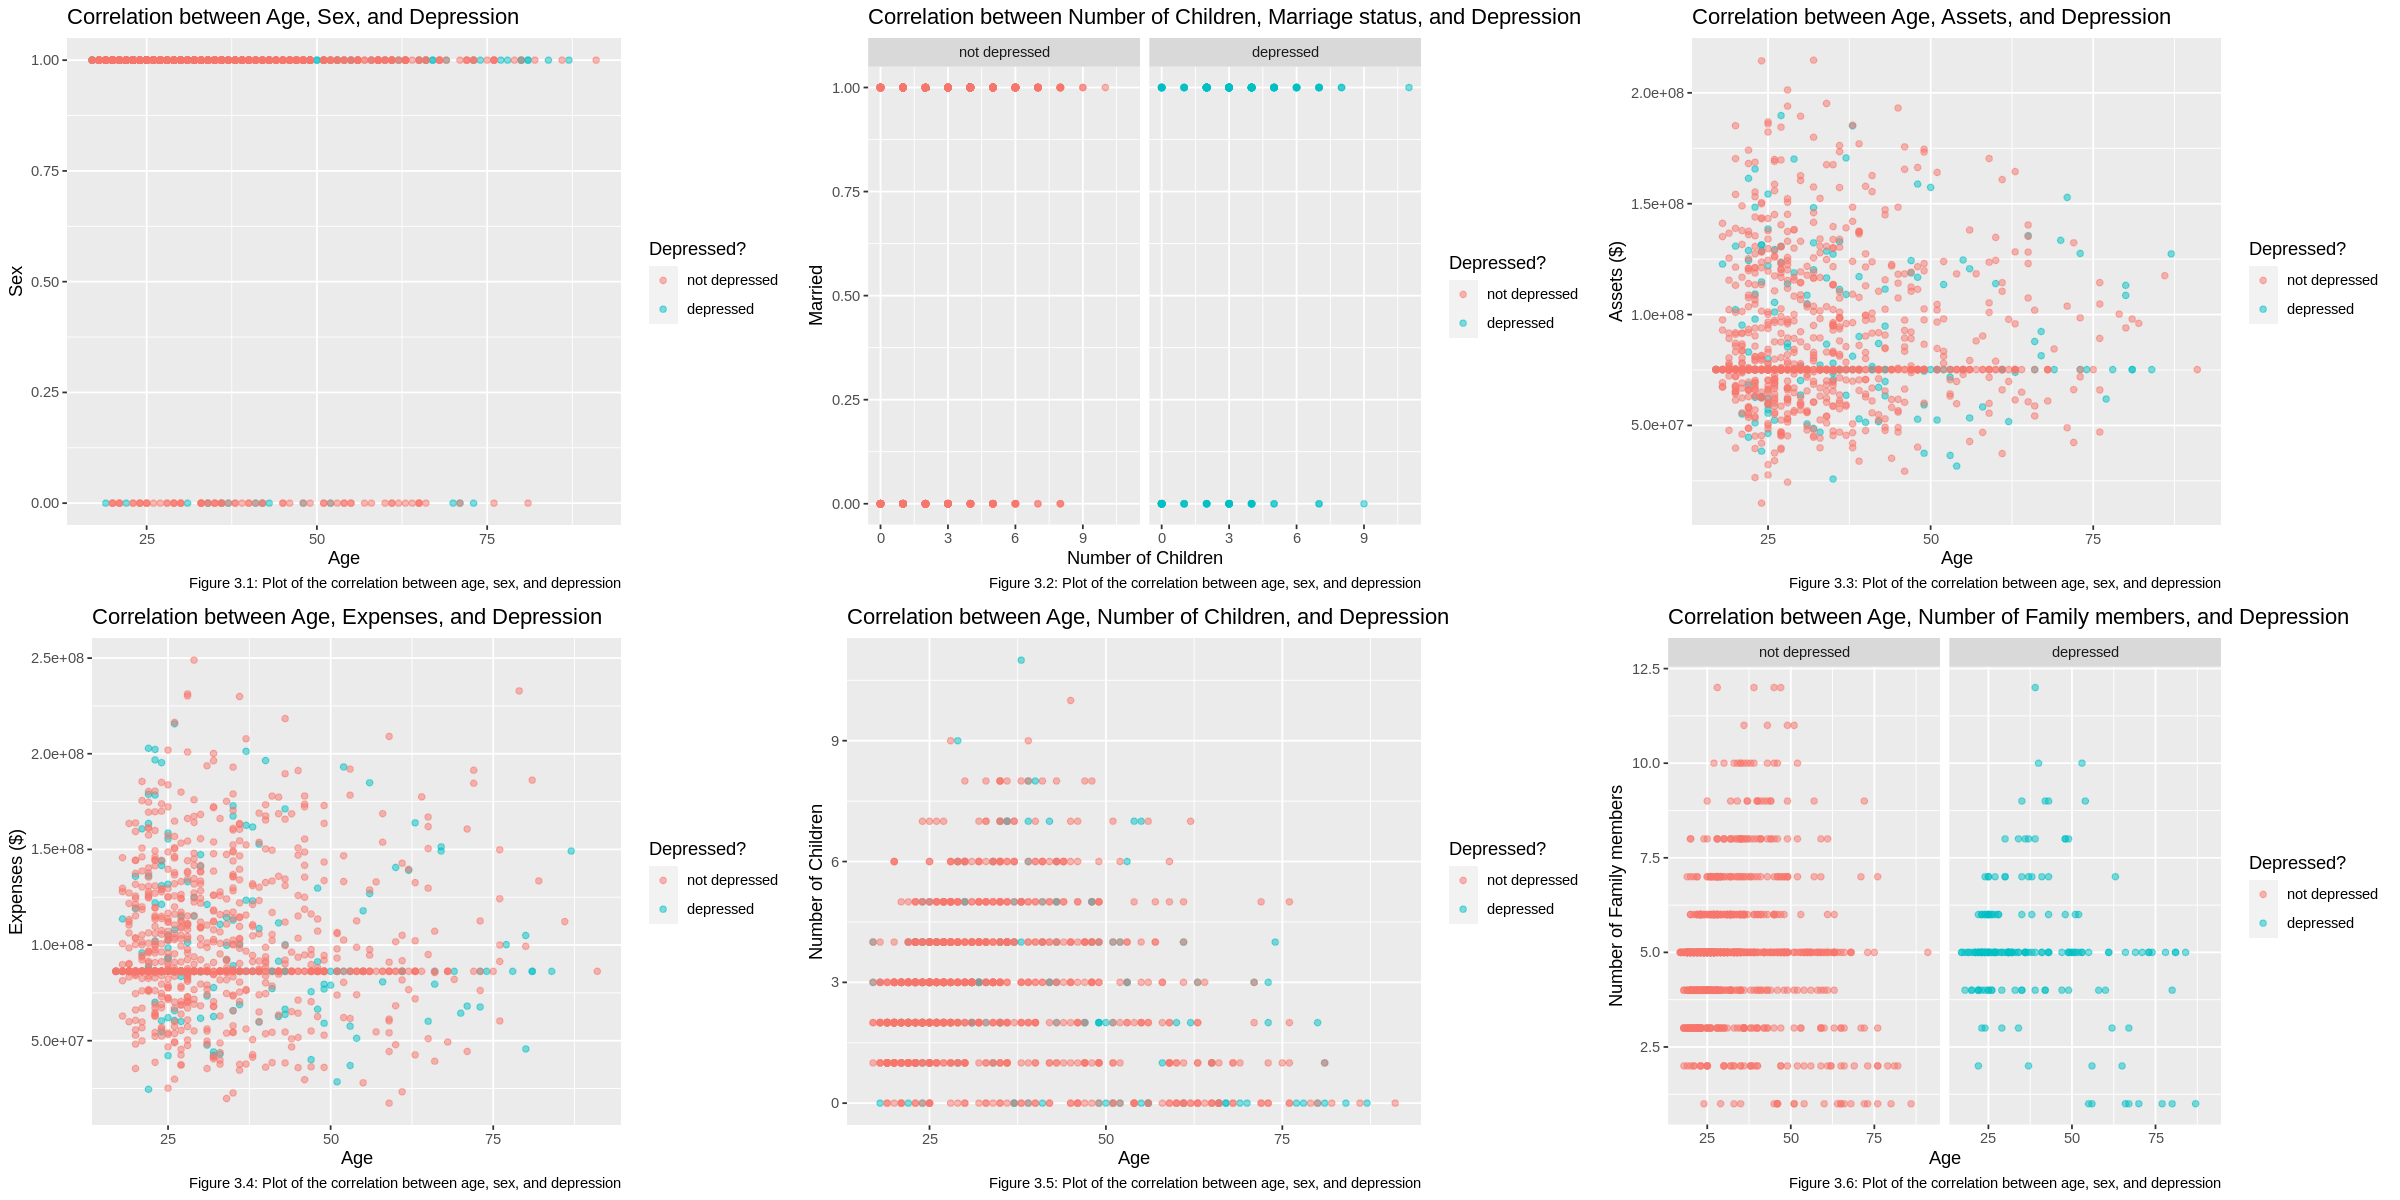

In [4]:
depression_data_plot1 <- depression_train |>
    ggplot(aes(x=Age, y=sex)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Sex", color="Depressed?", caption="Figure 3.1: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Sex, and Depression")

depression_data_plot2 <- depression_train |>
    ggplot(aes(x=Number_children, y=Married)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    facet_grid(cols = vars(depression_result)) +
    labs(x="Number of Children", y="Married", color="Depressed?", caption="Figure 3.2: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Number of Children, Marriage status, and Depression")

depression_data_plot3 <- depression_train |>
    ggplot(aes(x=Age, y=assets)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Assets ($)", color="Depressed?", caption="Figure 3.3: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Assets, and Depression")

depression_data_plot4 <- depression_train |>
    ggplot(aes(x=Age, y=expenses)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Expenses ($)", color="Depressed?", caption="Figure 3.4: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Expenses, and Depression")

depression_data_plot5 <- depression_train |>
    ggplot(aes(x=Age, y=Number_children)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Number of Children", color="Depressed?", caption="Figure 3.5: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Number of Children, and Depression")

depression_data_plot6 <- depression_train |>
    ggplot(aes(x=Age, y=total_members)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    facet_grid(cols = vars(depression_result)) +
    labs(x="Age", y="Number of Family members", color="Depressed?", caption="Figure 3.6: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Number of Family members, and Depression")

plot_grid(
    depression_data_plot1, depression_data_plot2, depression_data_plot3, depression_data_plot4, depression_data_plot5, depression_data_plot6
)


### Methods

For our analysis, we will be using the following columns from the dataset:
- sex
- Age
- married
- Number_children
- total_members
- gained_asset
- durable_asset
- save_asset
- living_expenses
- other_expenses
- depressed

To analyze the total assets, we will be using **mutate** function to add the columns *gained_asset*, *durable_asset*, and *save_asset* into one *asset* column.
To analyze the total expenses, we will be using **mutate** function to add the columns *living_expenses* and *other_expenses* into one *expenses* column.

To conduct our data analysis, we will clean our data so it only contains the columns we need, split our dataset into training and testing data, scale our data, use the 5 fold cross-validation technique to find our best k-nearest neighbors, then train our classification model so that it can predict whether someone is depress or not more accurately.

To visualize our results, we will create **scatterplots** of the scaled data using each *predictor* (variable) and colour the points based on whether they are predicted to be depressed or not. If our scatterplot is too difficult to read due to us having too many *predictors*, we will create scatterplots using only 2 predictors and see which ones show the best correlation for predicting depression.

Unfortunately, it was difficult to determine whether our predictor variables correlate with depression from the visualizations (Figure 3.1 - 3.6) and summary of our dataset (Figure 2) we made in our preliminary data analysis, but we planned on choosing to use the above variables because we believed that these variables are major causes to depression. Studies have shown that women (Mayo Clinic, 2019) and people dealing with financial hardships (Coelho, 2022) are more likely to develop depression-like disorders. This is most likely due to postpartum depression and because the more children one has, the more money they will need to have in order to raise them.

In this project, we will train a model to classify from the given data, whether or not someone is at risk of depression. We will use the knn-classification method to build our model. In addition to having a quick calculation time, we will also aim to for a high accuracy by tuning our classification model by finding the best knn value for our model. 

Additionally, through our preliminary analysis, we discovered that our data was not balanced (Figure 2) because we have a lot more data on "non_depressed", then "depressed" so we used the step_upsample() function from the themis library, together with the step_scale() and step_center() functions to balance and scale our data before building our model. 

### Expected outcomes and significance

We are expecting to predict whether someone from a rural area is likely to be depressed or not by specifying the factors listed above as predictors into the model.

We expect depression to be more common in women based on statistics from various news articles (Mayo Clinic, 2019), people with a lower income to be more at-risk of depression (Coelho, 2022), elderlies with very few family members, and teens with lots of family members, because they may have more pressure or be compared to their siblings a lot.

*Impacts of our findings:*
We are hoping that our findings can help others predict if their family or friends living in rural areas are likely to be depressed, and that our findings can help others in the medical field discover preventive measures that the most vulnerable population could take to reduce the risk of depression (if there are any). We are also hoping that our findings can enhance clinical support to the at-risk population by looking at the roots of why they are more likely to become depressed.

*Future questions our model could reach to:*
- What are some actions that could be taken in general to avoid depression and improve well-being (in relation to each column that are found closely correlated with mental illness)?
- How could the government increase accessibility of the rural community to medical support, especially patients diagnosed with depression?

# Data Analysis

In [5]:
set.seed(2)

# Getting training data
depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)

depression_train <- training(depression_data_split)
depression_test <- testing(depression_data_split)

### Training our classifier

In [6]:
set.seed(1000)

# Getting proportions
proportions <- depression_train |>
                      group_by(depression_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(depression_train))

# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit(data = depression_train)

depression_test_predictions <- predict(knn_fit, depression_test) |>
    bind_cols(depression_test)

depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 4: Dataset of the testing data with our predicted values

### Computing the accuracy of our model

In [7]:
confusion <- depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
confusion

depression_test_accuracy <- depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

cat("\nAccuracy: ", depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           214        45
  depressed                84        15


Accuracy:  0.6396648

###### Figure 5: The confusion matrix and accuracy of our model

### Tuning our Classifier

In [8]:
set.seed(2000)

depression_vfold <- vfold_cv(depression_train, v = 5, strata = depression_result)


# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()


knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = depression_vfold)

knn_fit |>
    collect_metrics()


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6591986,5,0.004557669,Preprocessor1_Model1
roc_auc,binary,0.5114443,5,0.016017641,Preprocessor1_Model1


###### Figure 6: Metrics of our model

### Finding the best number of neighbours K

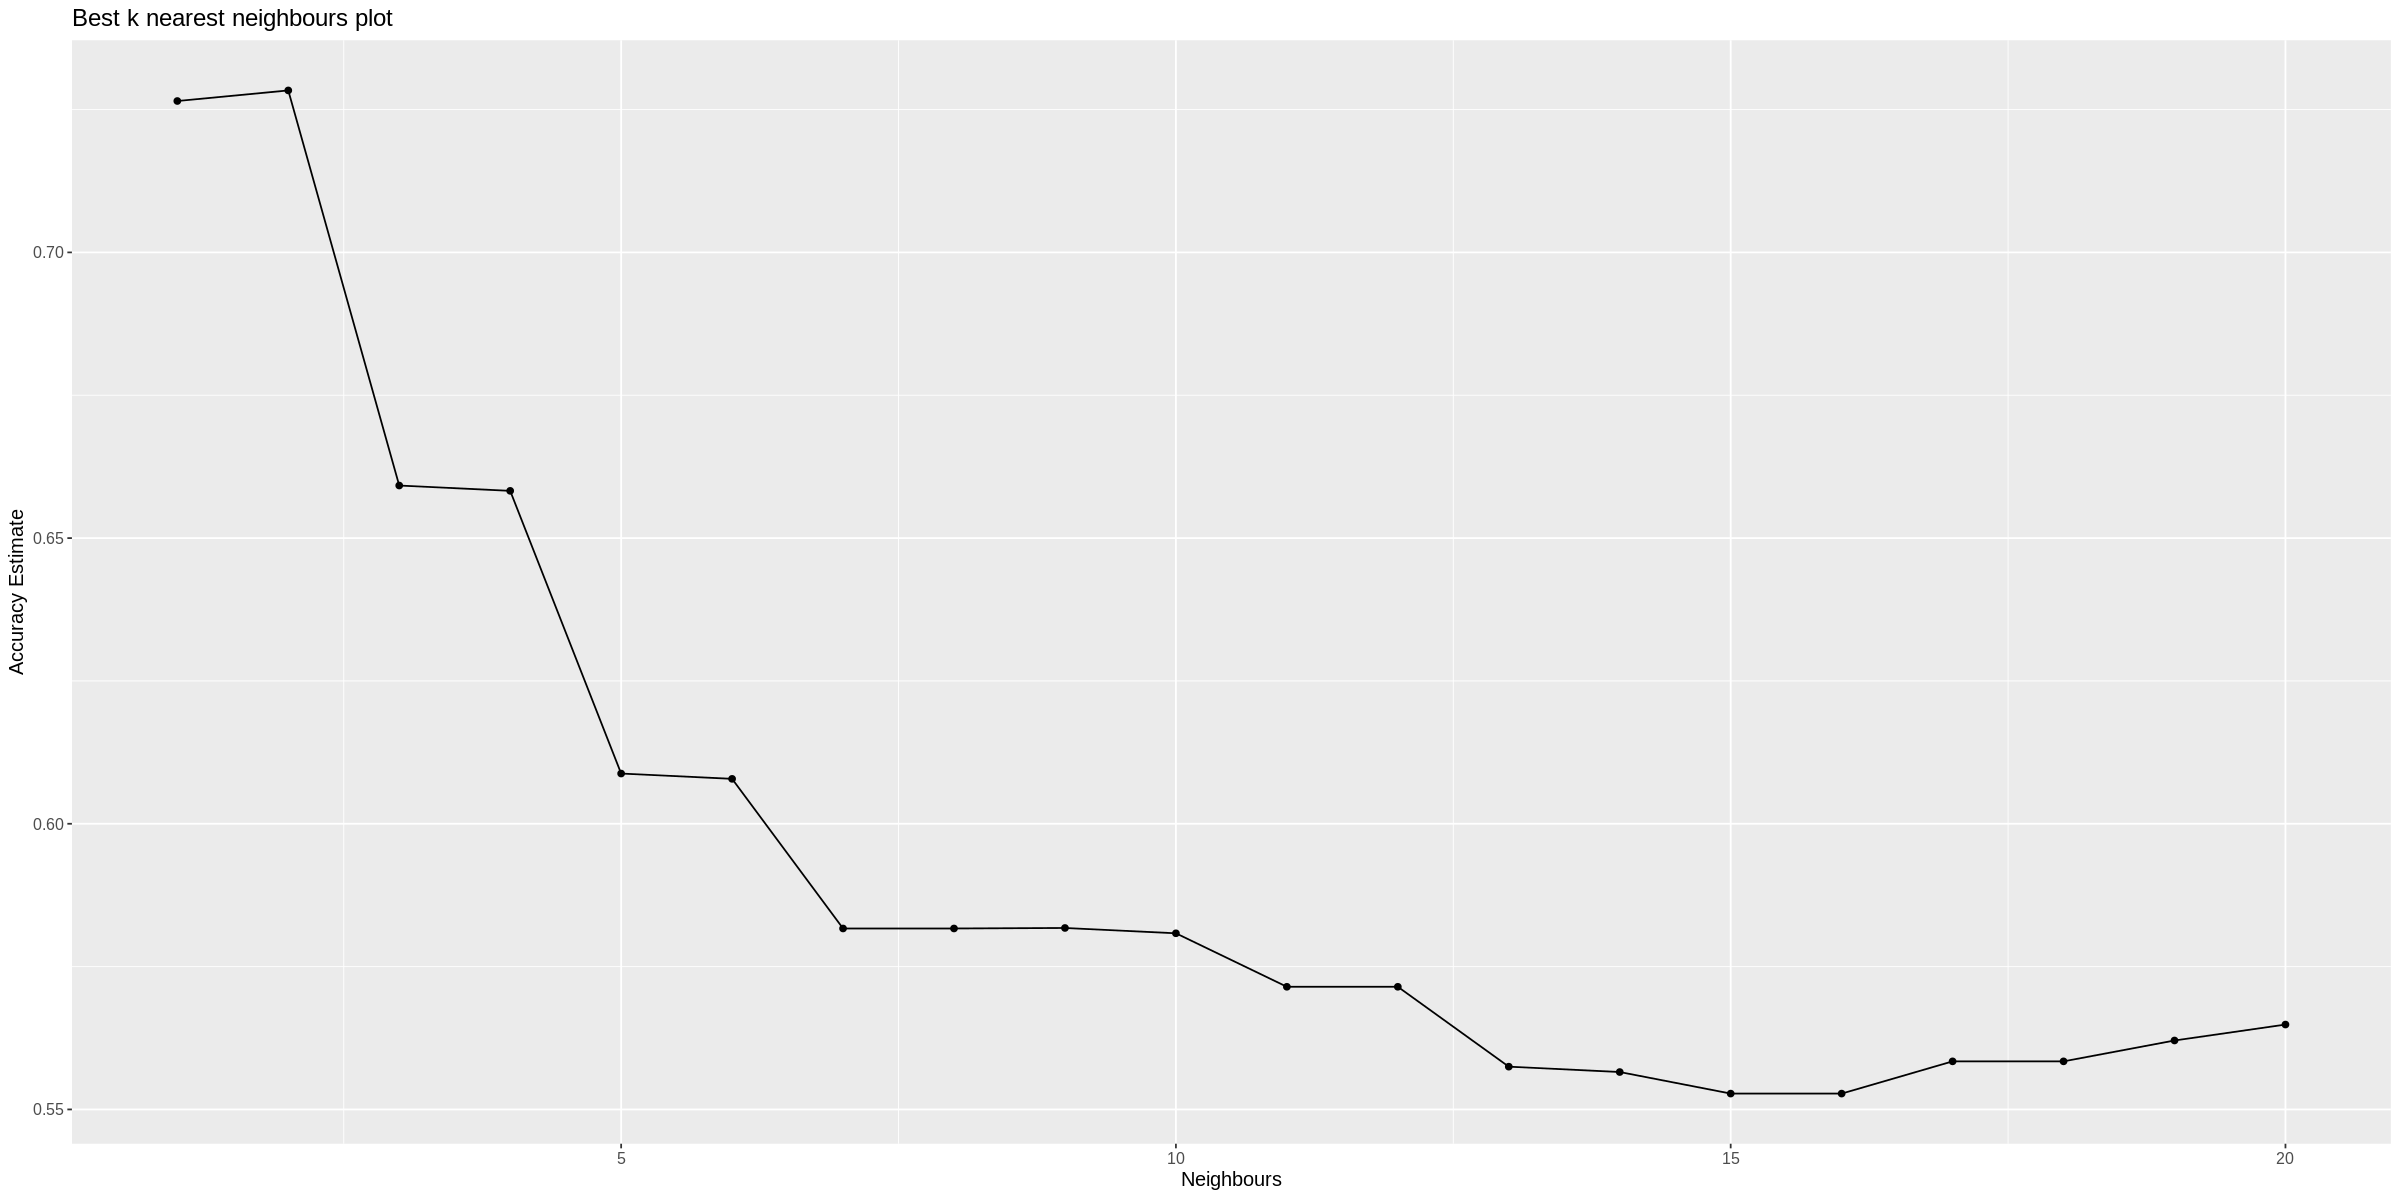

In [9]:
set.seed(4532)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = depression_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors) |>
    pull()

accuracy_vs_k <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate") +
    ggtitle("Best k nearest neighbours plot") +
    theme(text = element_text(size = 12))

accuracy_vs_k

###### Figure 7: Plot of knn values vs accuracy estimates

### Retraining our Classifier with the best k value

In [10]:
set.seed(4600)

# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit(data = depression_train)

depression_test_predictions <- predict(knn_fit, depression_test) |>
    bind_cols(depression_test)

depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 8: Dataset of the testing data with our predicted values after tuning our model

### Recomputing the accuracy of our model

In [11]:
tuned_depression_test_accuracy <- depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

confusion <- depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
confusion

cat("\nAccuracy: ", tuned_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           249        52
  depressed                49         8


Accuracy:  0.7178771

###### Figure 9: The confusion matrix and accuracy of our tuned model

### Building a new Classification model using Age, Sex, and Number of children as Predictors


In [12]:
set.seed(2)

# Filtering our data
depression_data <- depression_data |>
    select(sex, Age, Number_children, depression_result)

# Getting training data
new_depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)

new_depression_train <- training(new_depression_data_split)
new_depression_test <- testing(new_depression_data_split)

### Training our new classifier

In [13]:
set.seed(40)

# Getting proportions
new_proportions <- new_depression_train |>
                      group_by(depression_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(new_depression_train))

# Creating a recipe
new_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

new_knn_fit <- workflow() |>
    add_recipe(new_depression_recipe) |>
    add_model(new_knn_spec) |>
    fit(data = new_depression_train)

new_depression_test_predictions <- predict(new_knn_fit, new_depression_test) |>
    bind_cols(new_depression_test)

new_depression_test_predictions

.pred_class,sex,Age,Number_children,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,3,not depressed
not depressed,1,35,6,not depressed
not depressed,1,21,2,not depressed
⋮,⋮,⋮,⋮,⋮
not depressed,1,34,3,depressed
not depressed,1,25,3,not depressed
not depressed,1,35,6,not depressed


###### Figure 10: Dataset of the new testing data with our predicted values

### Computing the Accuracy of our new model

In [14]:
new_confusion <- new_depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
new_confusion

new_depression_test_accuracy <- new_depression_test_predictions |>
    metrics(truth = depression_result, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

cat("\nAccuracy: ", new_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           259        49
  depressed                39        11


Accuracy:  0.7541899

###### Figure 11: The new confusion matrix and accuracy of our model

### Tuning our new Classifier

In [15]:
set.seed(393)

depression_vfold <- vfold_cv(new_depression_train, v = 5, strata = depression_result)

# Creating a recipe
new_knn_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()


new_knn_fit <- workflow() |>
    add_recipe(new_knn_depression_recipe) |>
    add_model(new_knn_spec) |>
    fit_resamples(resamples = depression_vfold)

new_knn_fit |>
    collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7198733,5,0.01322297,Preprocessor1_Model1
roc_auc,binary,0.5167694,5,0.02489061,Preprocessor1_Model1


###### Figure 12: Metrics of our new model

### Finding the best number of neighbours K for our new classifier

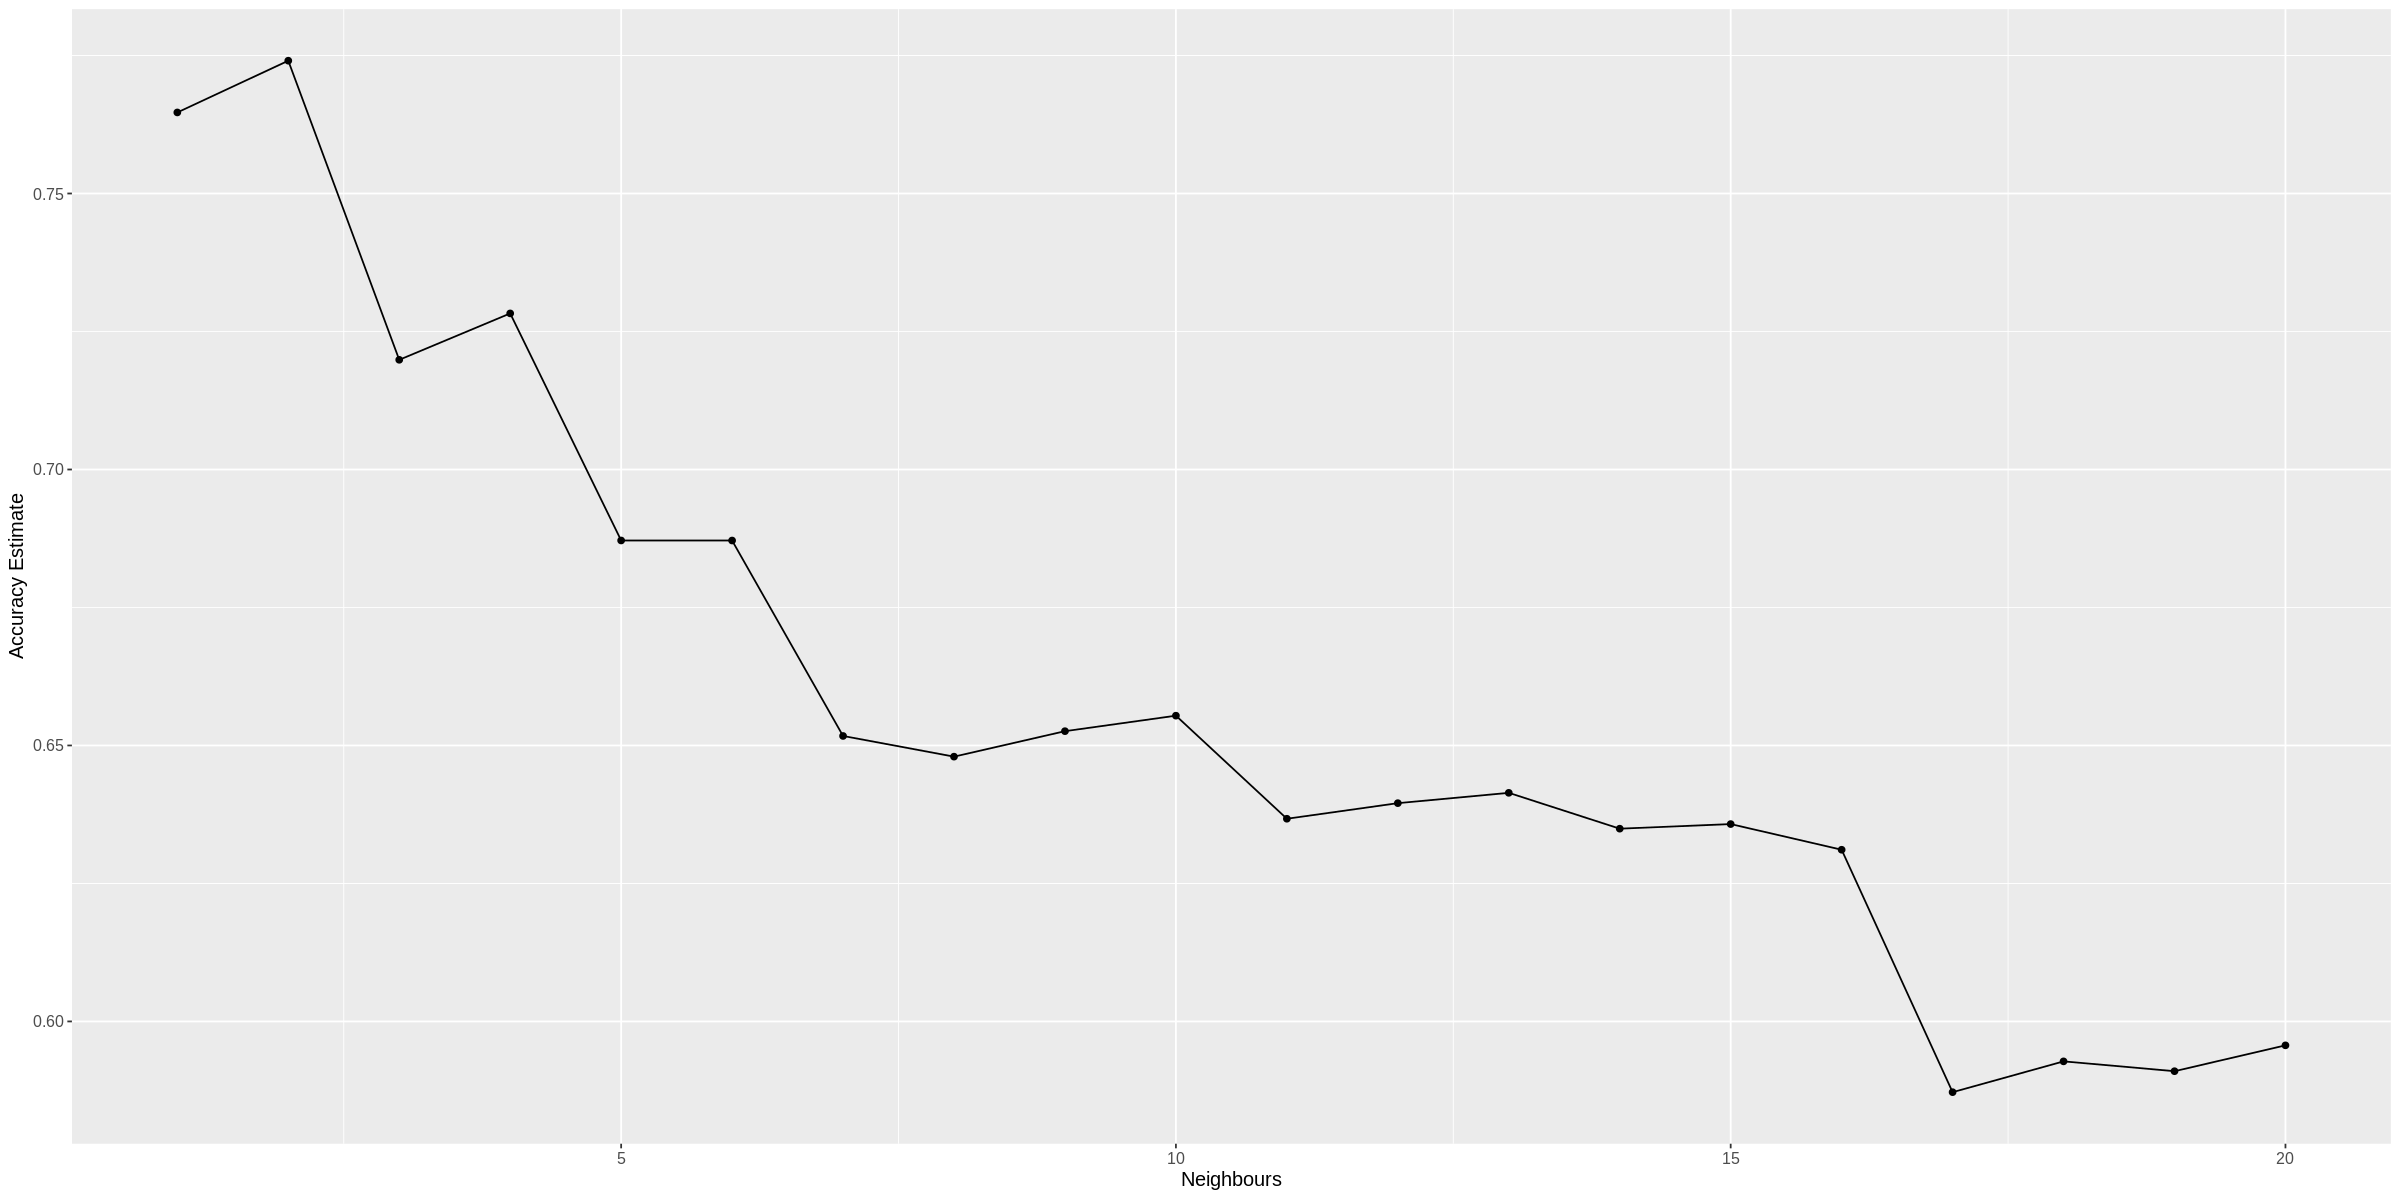

In [16]:
set.seed(3350)

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

new_knn_results <- workflow() |>
    add_recipe(new_knn_depression_recipe) |>
    add_model(new_knn_spec) |>
    tune_grid(resamples = depression_vfold, grid = k_vals) |>
    collect_metrics()

new_accuracies <- new_knn_results |>
  filter(.metric == "accuracy")

new_best_k <- new_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors) |>
    pull()
    
new_accuracy_vs_k <- new_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

new_accuracy_vs_k

###### Figure 13: Plot of knn values vs accuracy estimates

### Retraining our new Classifier with the best k value

In [17]:
set.seed(1250)

# Creating a recipe

new_tuned_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

new_tuned_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = new_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

new_tuned_knn_fit <- workflow() |>
    add_recipe(new_tuned_depression_recipe) |>
    add_model(new_tuned_knn_spec) |>
    fit(data = new_depression_train)

new_tuned_depression_test_predictions <- predict(new_tuned_knn_fit, new_depression_test) |>
    bind_cols(new_depression_test)

new_tuned_depression_test_predictions

.pred_class,sex,Age,Number_children,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,3,not depressed
not depressed,1,35,6,not depressed
not depressed,1,21,2,not depressed
⋮,⋮,⋮,⋮,⋮
not depressed,1,34,3,depressed
not depressed,1,25,3,not depressed
not depressed,1,35,6,not depressed


###### Figure 14: Dataset of the testing data with our predicted values after tuning our new model

### Recomputing the accuracy of our new model

In [18]:
new_tuned_confusion <- new_tuned_depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
new_tuned_confusion

new_tuned_depression_test_accuracy <- new_tuned_depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

cat("\nAccuracy: ", new_tuned_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           283        54
  depressed                15         6


Accuracy:  0.8072626

###### Figure 15: The confusion matrix and accuracy of our new tuned model

## Summary

Based on our data analysis, we were able to build a depression classification model with a 71.79% accuracy (Figure 9), and another classification model with a 80.73% accuracy (Figure 15). 

For our first classification model (Figure 9), we achieved an accuracy of 71.79% and successfully predicted that someone is not depressed 249 out of 298 times which we thought was pretty good. However, it only correctly predicted that someone is depressed 8 out of 60 times, which we weren't too happy about.

We determined that some of the predictors selected might not directly relate to depression as shown by the scatterplots (Figure 3) we created in our preliminary data analysis because the correlation in some scatterplots (Figure 3) are weak and do not strongly show that these variables could cause depression or prevent someone from being depressed. As a result, we decided to create a new classification model by only selecting "Age", "Sex", and "Number_children" (number of children one has), as our predictors because these 3 variables show at least some correlation for depression.

As shown in the confusion matrix (Figure 15), the new classification model had an accuracy of 80.73% and successfully predicted that someone is not depressed 283 out of 298 times which was even better than the first classification model. However, it only correctly predicted that someone is depressed 6 out of 60 times, which was worse. To put this into simpler words, 54 "depressed" individuals were classified as "not depressed" and 15 individuals who are "not depressed" were mistakenly identified as "depressed". Additionally, when tuning our models and creating the new classifier, we noticed that as accuracy increases, the chances of our model correctly predicting that someone is "not_depressed" increases, but its ability to predict whether someone is "depressed" worsens. This may be because our dataset contains more data on "not_depressed" than "depressed", so accuracy drastically increases whenever we correctly classify someone as "not_depressed" and the accuracy doesn't change that much if we correctly classify someone as "depressed".

Although we were expecting that the second classification model would have a higher accuracy, we did not expect that its predictions for whether someone is depressed would worsen because we filtered out predictors we thought would not relate to depression. However, based on our preliminary analysis, we weren't expecting high accuracy rates for our models because based on our visualizations (Figure 3), it looked like almost none of our variables correlated with depression, so we were pretty surprised when we got a 71.79% accuracy for our first model. 

Although the new model still had a few errors in predicting depression, it provides a rough prediction on whether or not an individual is vulnerable to being depressed. The second model is better at predicting "not depressed" individuals and could be impactful as we can help people who believe they are depressed find out if they are actually depressed or not. However, the huge risk is that a depressed individual may be classified as "not depressed" and may decide that they do not need to reach out for help, which will further negatively affect their mental health. As for our first classification model, although it had a lower accuracy rate, it correctly predicted that someone is "depressed" more than the new classifier did, which may be more useful in the healthcare field as we believe it is better to correctly identify whether an individual is depressed or not so they can seek immediate help, then to wrongly classify someone as depressed when they are not depressed. As a result, we believe that sex, age, whether someone is married or not, number of children and household members one has, assets, and expenses do indeed correlate with depression, even if it only has a tiny affect, because our classification model with all 6 predictors successfully predicted that an individual is depressed more then our second model with fewer predictors did.

Future questions that this could lead to are:
- How can we help reduce depression rates for individuals living in rural areas?
- What other variables can lead to depression?
- Does sex, age, whether someone is married or not, number of children and household members one has, assets, and expenses actually relate to depression or are there some variables that do not?

## References

Babativa, Diego. (2019, December 28). “Depression Dataset.” Kaggle. Retrieved October 26th, 2022, from https://www.kaggle.com/datasets/diegobabativa/depression. 

Mayo Foundation for Medical Education and Research. (2019, January 29). Women's increased risk of depression. Mayo Clinic. Retrieved December 7, 2022, from https://www.mayoclinic.org/diseases-conditions/depression/in-depth/depression/art-20047725

Coelho, S. (2022, April 7). Can the wealthy live with depression? Psych Central. Retrieved December 7, 2022, from https://psychcentral.com/depression/are-wealthy-people-more-depressed-than-others